# Input formatting and tokenization
### Necessary imports and definitions

In [1]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

'test' is not recognized as an internal or external command,
operable program or batch file.
'test' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'bertviz_repo' already exists and is not an empty directory.


In [2]:
from bertviz import model_view, head_view
from metrics import Evaluate
from transformers import *

import numpy as np
import pprint
import pandas as pd

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

C:\Users\user\anaconda3\envs\myenv\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


### The BioBERT model will be used

In [3]:
model_path = 'dmis-lab/biobert-v1.1'

CLS_token = "[CLS]"
SEP_token = "[SEP]"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

loading configuration file config.json from cache at C:\Users\user/.cache\huggingface\hub\models--dmis-lab--biobert-v1.1\snapshots\551ca18efd7f052c8dfa0b01c94c2a8e68bc5488\config.json
Model config BertConfig {
  "_name_or_path": "dmis-lab/biobert-v1.1",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at C:\Users\user/.cache\huggingface\hub\models--dmis-lab--biobert-v1.1\snapshots\551ca18efd7f052c8dfa0b01c94c2a8e68bc5488\v

### The query, a relevant document and a non-relvant document

In [5]:
from os.path import exists
import data_loading as d_load
import pickle

if (exists('train_data.obj') and 
    exists('test_data.obj') and 
    exists('trials_data.obj')):
    
    #load the objects from pickle
    file_data = open('train_data.obj', 'rb') 
    train = pickle.load(file_data)
    file_data.close()
    
    file_data = open('test_data.obj', 'rb') 
    test = pickle.load(file_data)
    file_data.close()
    
    file_data = open('trials_data.obj', 'rb') 
    trials = pickle.load(file_data)
    file_data.close()

else:
    
    train, test = d_load.load_and_split_queries()
    trials = d_load.load_evaluated_trials()

    #Save the data objects to files
    file_data = open('train_data.obj', 'wb') 
    pickle.dump(train, file_data)
    file_data.close()

    file_data = open('test_data.obj', 'wb') 
    pickle.dump(test, file_data)
    file_data.close()

    file_data = open('trials_data.obj', 'wb') 
    pickle.dump(trials, file_data)
    file_data.close()

In [6]:
query_1 = train[5].query_content
rel_doc_1 = trials.description['NCT00525655']
n_rel_doc_1 = trials.description['NCT00485069']

query_2 = train[10].query_content
rel_doc_2 = trials.description['NCT01206491']
n_rel_doc_2 = trials.description['NCT00170339']

query_3 = train[26].query_content
rel_doc_3 = trials.description['NCT01258634']
n_rel_doc_3 = trials.description['NCT00005033']

### Encdoing the texts

In [7]:
query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [8]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '21', '-', 'year', '-', 'old', 'male', 'with', 'dozens',
       'of', 'small', 'p', '##oly', '##ps', 'found', 'on', 'co', '##lon',
       '##os', '##copy', '.', 'Family', 'history', 'significant', 'for',
       'both', 'older', 'siblings', 'having', 'total', 'co', '##lect',
       '##omi', '##es', 'after', 'co', '##lon', '##os', '##copy',
       'revealed', 'hundreds', 'of', 'ad', '##eno', '##mas', '.', '[SEP]',
       'Study', 'Part', '##ici', '##pation', ':', 'If', 'you', 'agree',
       'to', 'take', 'part', 'in', 'this', 'study', ',', 'you', 'will',
       'view', 'the', 'website', ',', 'take', 'part', 'in', 'a', 'one',
       '-', 'on', '-', 'one', 'interview', 'or', 'a', 'small', 'group',
       'discussion', '(', 'a', 'focus', 'group', ')', ',', 'and', 'one',
       'or', 'more', 'question', '##naire', '##s', '.', 'You', 'may',
       'come', 'to', 'M', '.', 'D', '.', 'Anderson', 'to', 'take', 'part',
       'in', 'this', 'study', ',', 'which', 'may', 'take', 'pl

In [26]:
#query, doc = query_1, rel_doc_1
query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [10]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '21', '-', 'year', '-', 'old', 'male', 'with', 'dozens',
       'of', 'small', 'p', '##oly', '##ps', 'found', 'on', 'co', '##lon',
       '##os', '##copy', '.', 'Family', 'history', 'significant', 'for',
       'both', 'older', 'siblings', 'having', 'total', 'co', '##lect',
       '##omi', '##es', 'after', 'co', '##lon', '##os', '##copy',
       'revealed', 'hundreds', 'of', 'ad', '##eno', '##mas', '.', '[SEP]',
       'R', '##E', '##Q', '##UI', '##P', '(', 'R', '##op', '##ini',
       '##rol', '##e', 'H', '##ydro', '##ch', '##lor', '##ide', ')', 'I',
       '##R', 'Long', '-', 'Te', '##rm', 'Phase', '4', 'Study', '##R',
       '##op', '##ini', '##rol', '##e', 'H', '##ydro', '##ch', '##lor',
       '##ide', '(', 'R', '##OP', ')', 'was', 'granted', 'approval',
       'for', 'the', 'treatment', 'of', 'Parkinson', "'", 's', 'Disease',
       '(', 'PD', ')', 'on', '20', 'October', '2006', '.', 'R', '##OP',
       'is', 'expected', 'to', 'be', 'used', 'for', 'a', 'long', 'te

In [11]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [12]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '51', '-', 'year', '-', 'old', 'smoke', '##r', 'with',
       'h', '##yper', '##tens', '##ion', 'and', 'diabetes', ',', 'in',
       'men', '##op', '##aus', '##e', ',', 'needs', 'recommendations',
       'for', 'preventing', 'o', '##ste', '##op', '##oro', '##sis', '.',
       '[SEP]', 'Department', 'of', 'Ch', '##ronic', 'Disease', 'and',
       'Health', 'Promotion', 'of', 'World', 'Health', 'Organization',
       'listed', 'eight', 'classes', 'of', 'chronic', 'disease', 'which',
       'will', 'be', 'important', 'globally', 'in', 'the', 'future', '.',
       'And', 'the', 'sixth', 'class', 'is', '"', 'Ch', '##ronic', 'R',
       '##he', '##umatic', 'Con', '##dition', '"', ',', 'which',
       'includes', 'r', '##he', '##umatic', 'art', '##hr', '##itis', ',',
       'o', '##ste', '##oar', '##th', '##rit', '##is', ',', 'o', '##ste',
       '##op', '##oro', '##sis', ',', 'spinal', 'disorders', 'and',
       'severe', 'limb', 'trauma', '.', 'Obviously', 'the', 'o', '##ste

In [13]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [14]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '51', '-', 'year', '-', 'old', 'smoke', '##r', 'with',
       'h', '##yper', '##tens', '##ion', 'and', 'diabetes', ',', 'in',
       'men', '##op', '##aus', '##e', ',', 'needs', 'recommendations',
       'for', 'preventing', 'o', '##ste', '##op', '##oro', '##sis', '.',
       '[SEP]', 'Ch', '##ronic', 'use', 'of', 'op', '##iate', '##s',
       'has', 'long', 'been', 'associated', 'with', 'multiple', 'side',
       'effects', ',', 'many', 'of', 'which', 'are', 'due', 'to', 'lower',
       'levels', 'of', 'and', '##rogen', '##s', 'in', 'this', 'patient',
       'population', '.', 'Previous', 'studies', 'have', 'shown', 'that',
       'long', '-', 'term', 'op', '##iate', 'use', 'may', 'lead', 'to',
       'na', '##rc', '##otic', 'induced', 'h', '##y', '##po', '##gon',
       '##adi', '##sm', ',', 'resulting', 'in', 'significantly',
       'decreased', 'test', '##osterone', 'levels', 'in', 'men', '.',
       'One', 'area', 'of', 'chronic', 'op', '##iate', 'use', 'that',
   

In [15]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [16]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '10', '-', 'year', '-', 'old', 'boy', 'with',
       'progressive', 'right', 'knee', 'and', 'left', 'leg', 'pain',
       'and', 'ed', '##ema', ',', 'let', '##har', '##gy', 'and', 'an',
       'o', '##ste', '##oly', '##tic', 'les', '##ion', '.', 'No',
       'history', 'of', 'trauma', ',', 'fever', ',', 'ta', '##chy',
       '##card', '##ia', ',', 'or', 'u', '##rina', '##ry', 'in', '##con',
       '##tine', '##nce', '.', '[SEP]', 'A', 'Study', 'of', 'Pre', '-',
       'Opera', '##tive', 'Treatment', 'of', 'New', '##ly', '-', 'Di',
       '##ag', '##nose', '##d', ',', 'Sur', '##gical', '##ly', '-', 'Re',
       '##sect', '##able', 'O', '##ste', '##osa', '##rc', '##oma', 'With',
       'Do', '##x', '##or', '##ubi', '##cin', ',', 'If', '##os', '##fa',
       '##mi', '##de', ',', 'E', '##top', '##os', '##ide', ',', 'and',
       'C', '##is', '##p', '##lat', '##in', 'With', 'Early', 'Met',
       '##ab', '##olic', 'Assessment', 'of', 'Response', '##T', '##his',
       'is', 

In [17]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

In [18]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
pprint.pprint(tokens)

array(['[CLS]', '10', '-', 'year', '-', 'old', 'boy', 'with',
       'progressive', 'right', 'knee', 'and', 'left', 'leg', 'pain',
       'and', 'ed', '##ema', ',', 'let', '##har', '##gy', 'and', 'an',
       'o', '##ste', '##oly', '##tic', 'les', '##ion', '.', 'No',
       'history', 'of', 'trauma', ',', 'fever', ',', 'ta', '##chy',
       '##card', '##ia', ',', 'or', 'u', '##rina', '##ry', 'in', '##con',
       '##tine', '##nce', '.', '[SEP]', 'O', '##B', '##J', '##EC', '##TI',
       '##VE', '##S', ':', '-', 'Det', '##er', '##mine', 'the',
       'response', 'rate', ',', 'freedom', 'from', 'progression', ',',
       'and', 'survival', 'of', 'patients', 'with', 're', '##current',
       'o', '##ste', '##osa', '##rc', '##oma', 'when', 'treated', 'with',
       't', '##ras', '##tu', '##zu', '##ma', '##b', '(', 'Her', '##ce',
       '##pt', '##in', ')', '.', '-', 'Eva', '##lu', '##ate', 'the',
       'toxicity', 'of', 'this', 'drug', 'in', 'young', 'patients',
       'with', 'a', 'histo

# Layer embeddings visualization

In [19]:
query, doc = query_2, rel_doc_2
inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))

In [20]:
#token_idx = [1, 3, 14, -31, -30, 37, -7, -6, -5, -4, -3]
token_idx = [-54, -53, 1, 3, 9, 10, 11, 12, 6, 7]
tokens_pca = tokens[token_idx]

### Get the embeddings and corresponding tokens

In [21]:
with torch.no_grad():
    outputs = model(**inputs)
    
last_embeddings = outputs['last_hidden_state'][0][token_idx]
first_embeddings = outputs['hidden_states'][1][0][token_idx]

### Plot of embeddings

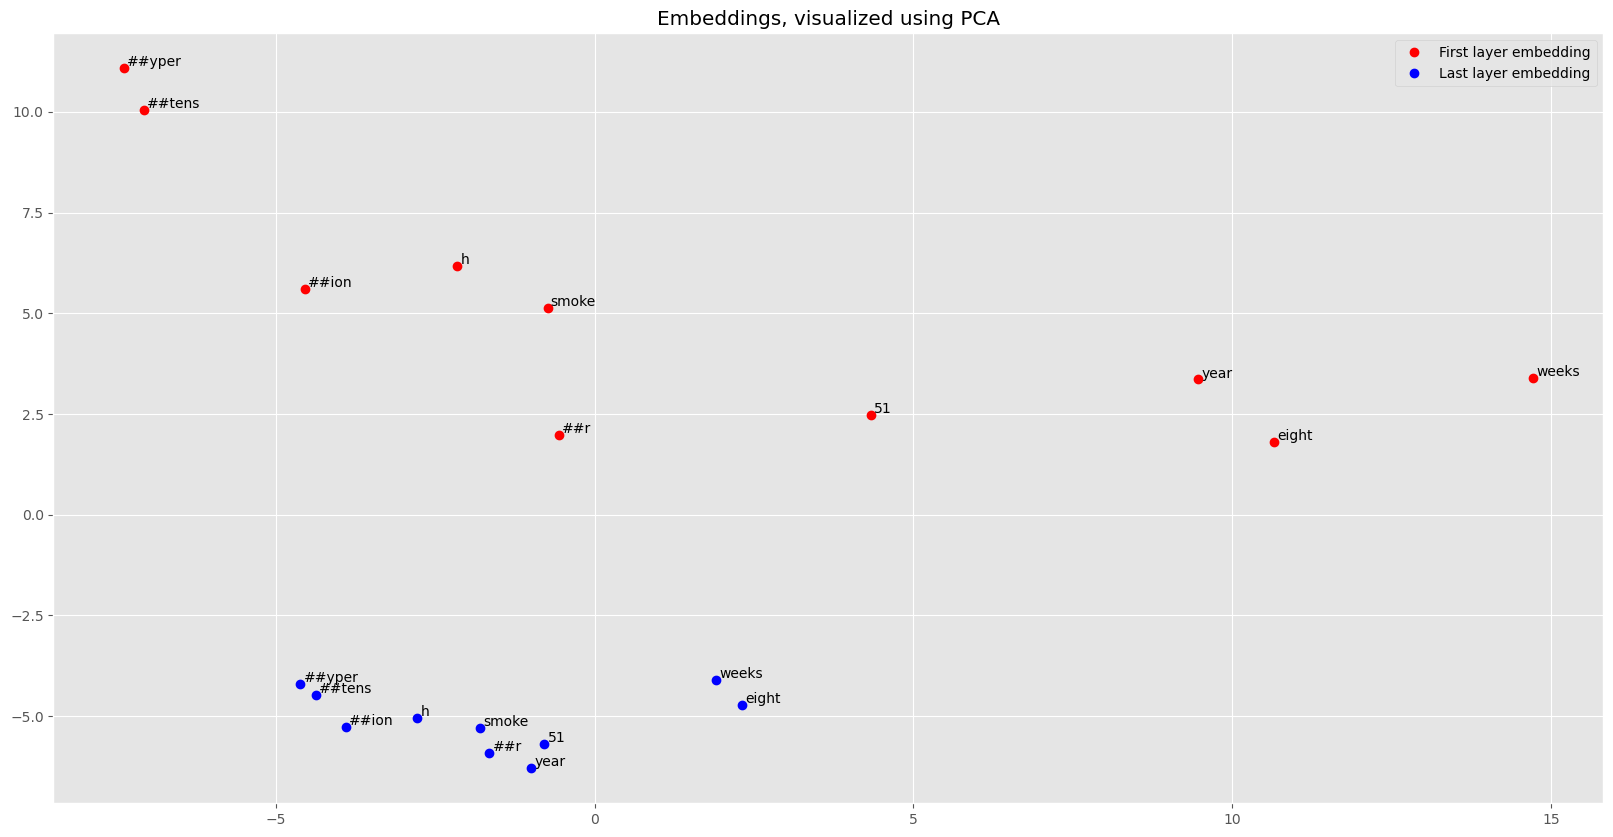

In [22]:
pca = PCA(n_components=2).fit(torch.cat((first_embeddings, last_embeddings), axis=0))
first_pca = pca.transform(first_embeddings)
last_pca = pca.transform(last_embeddings)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(first_pca[:, 0], first_pca[:, 1], 'ro')
for word, (x,y) in zip(tokens_pca, first_pca):
        plt.text(x+0.05, y+0.05, word)
        
plt.plot(last_pca[:, 0], last_pca[:, 1], 'bo')
for word, (x,y) in zip(tokens_pca, last_pca):
        plt.text(x+0.05, y+0.05, word)

plt.legend(['First layer embedding', 'Last layer embedding'])
plt.title('Embeddings, visualized using PCA')
plt.show()

# Layer embeddings similarity visualization

### Dot product - used to calculate the similarity between embeddings

In [23]:
def dot(t1, t2):
    n_dim = t1.shape[1]
    t2_T = torch.transpose(t2, 0, 1)
    product = torch.matmul(t1, t2_T)/np.sqrt(n_dim)
    return product

## First query-document pair

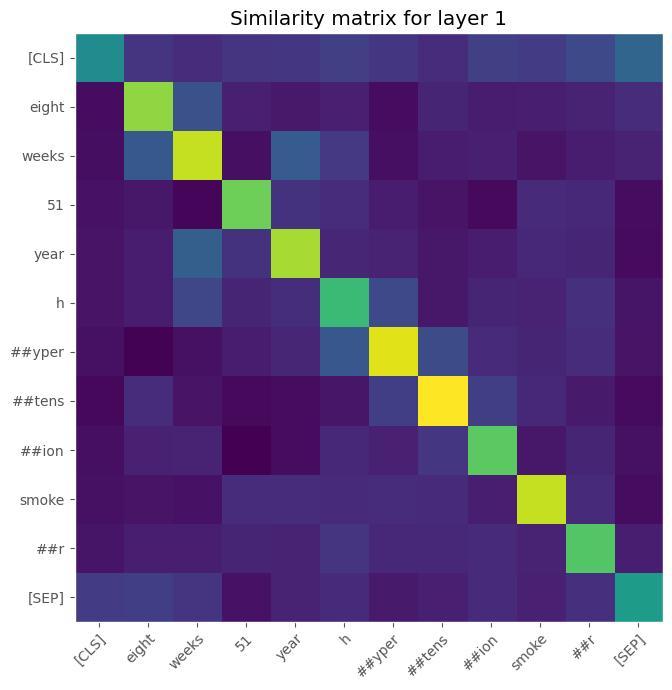

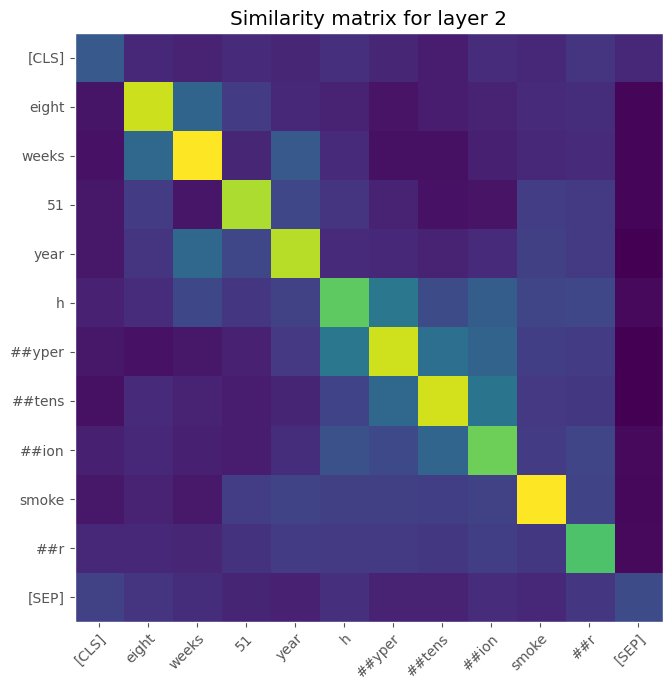

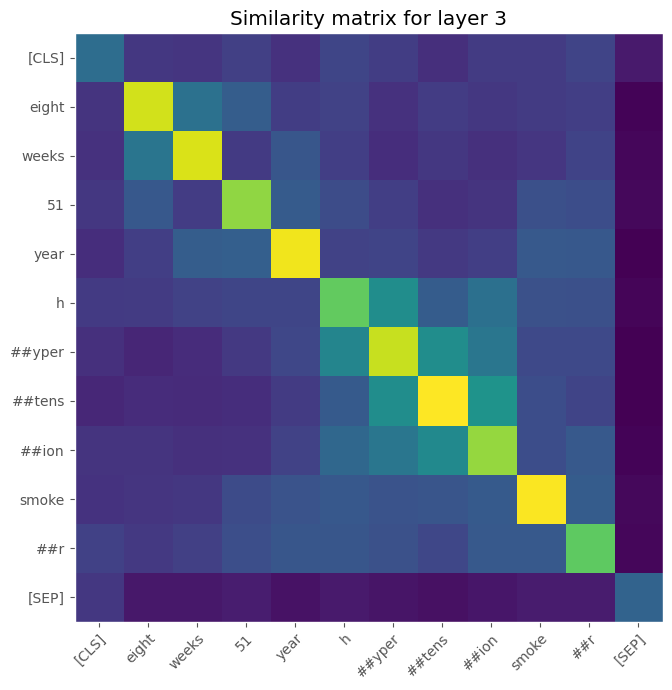

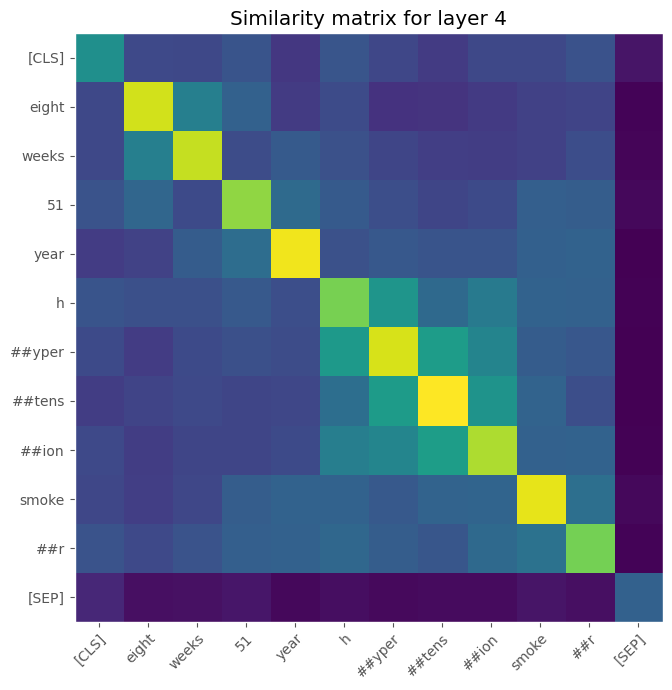

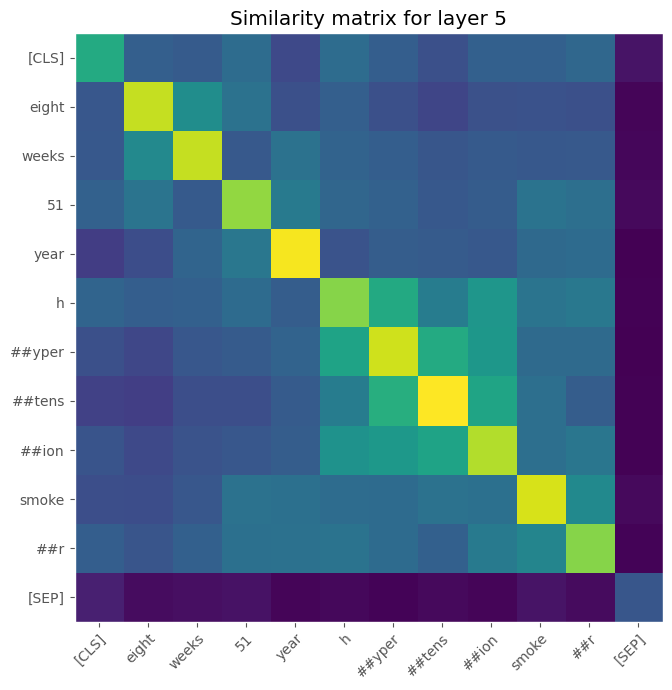

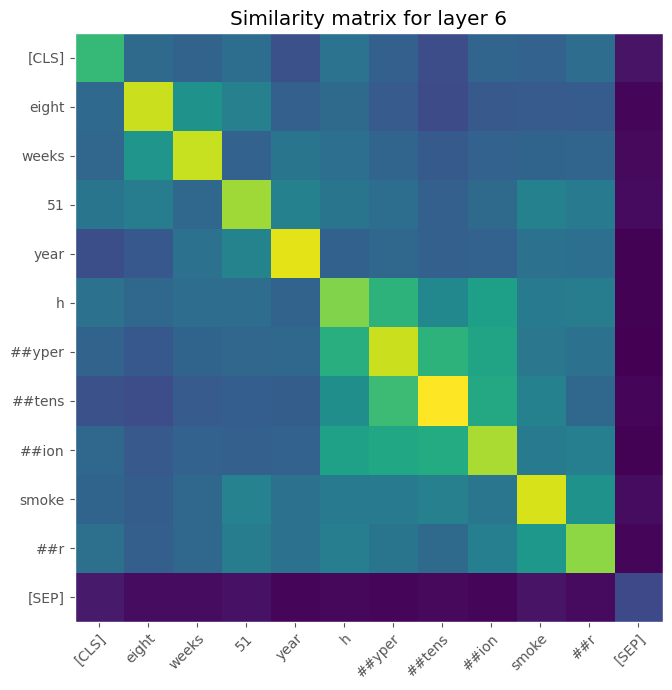

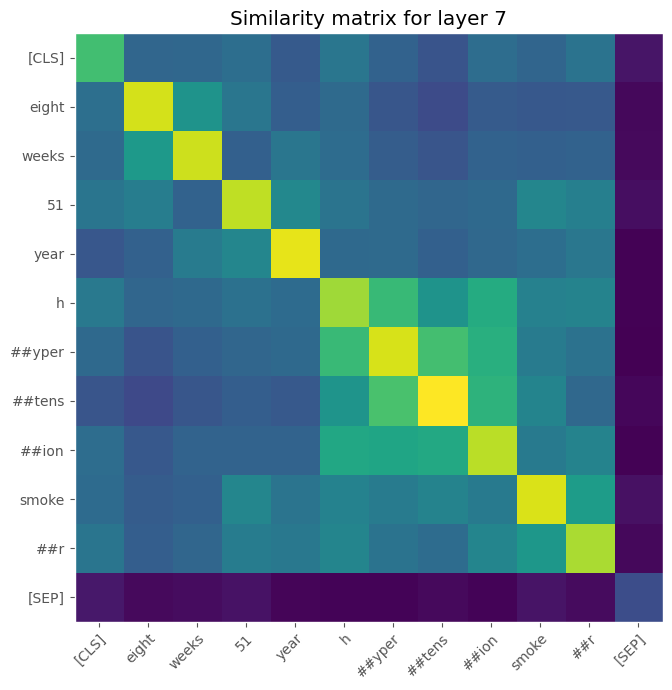

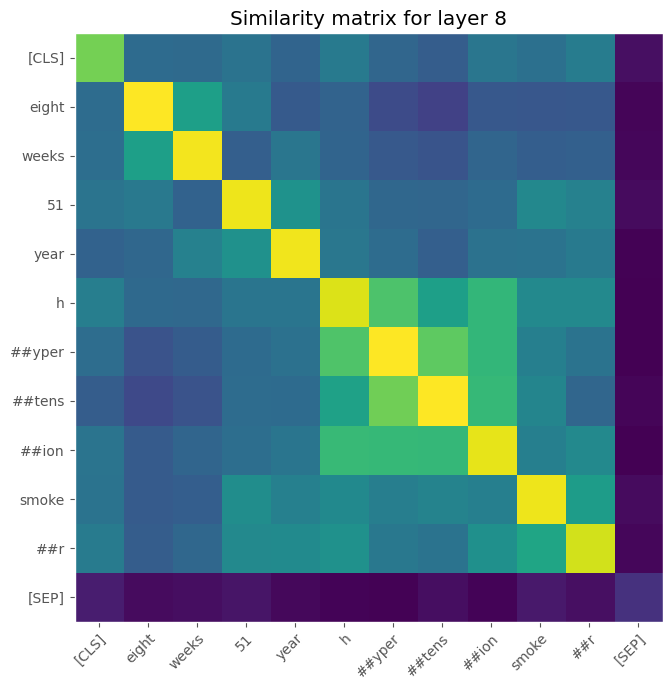

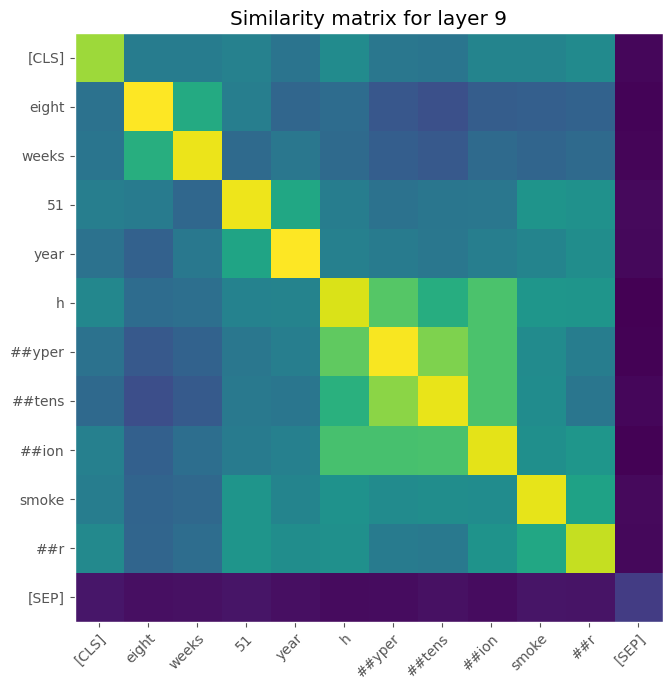

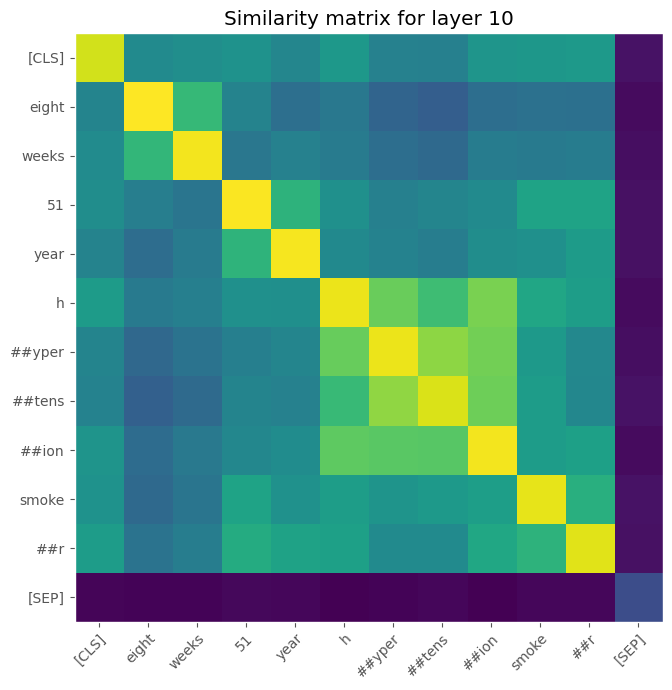

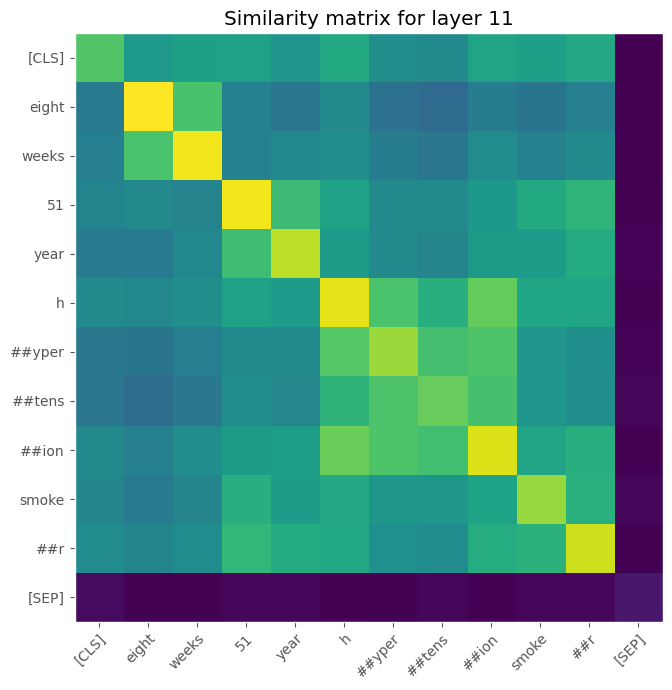

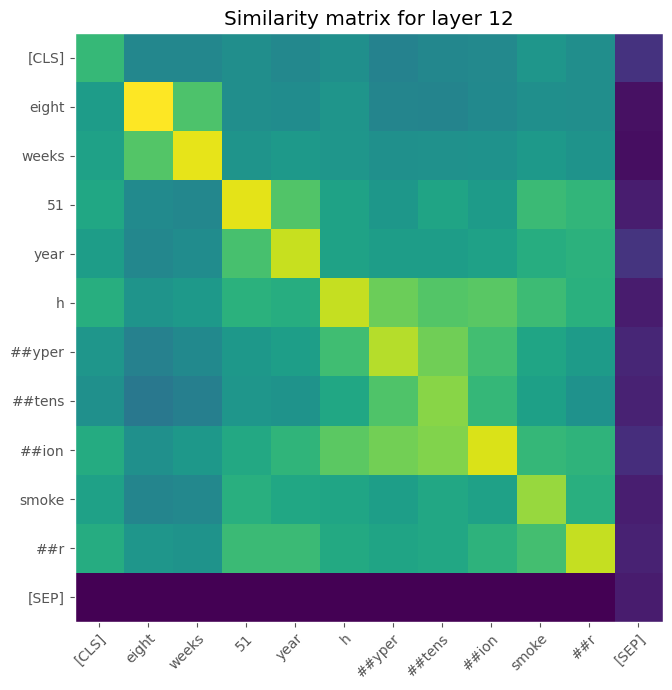

In [24]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

query, doc = query_2, rel_doc_2
token_idx = [0, -54, -53, 1, 3, 9, 10, 11, 12, 6, 7, -1]
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

with torch.no_grad():
    outputs = model(**inputs)
    
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
    
plt.rcParams["axes.grid"] = False

for i in range(0, 12):
    layer_input = outputs['hidden_states'][i][0][token_idx]
    layer_output = outputs['hidden_states'][i+1][0][token_idx]
    
    similarity_matrix = dot(layer_input, layer_output)

    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(7)
    
    im = ax.imshow(similarity_matrix)
    l = similarity_matrix.shape[0]

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(l), labels=tokens[token_idx])
    ax.set_yticks(np.arange(l), labels=tokens[token_idx])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Similarity matrix for layer %d" % (i+1))
    fig.tight_layout()
    plt.show()

## Another query-document pair

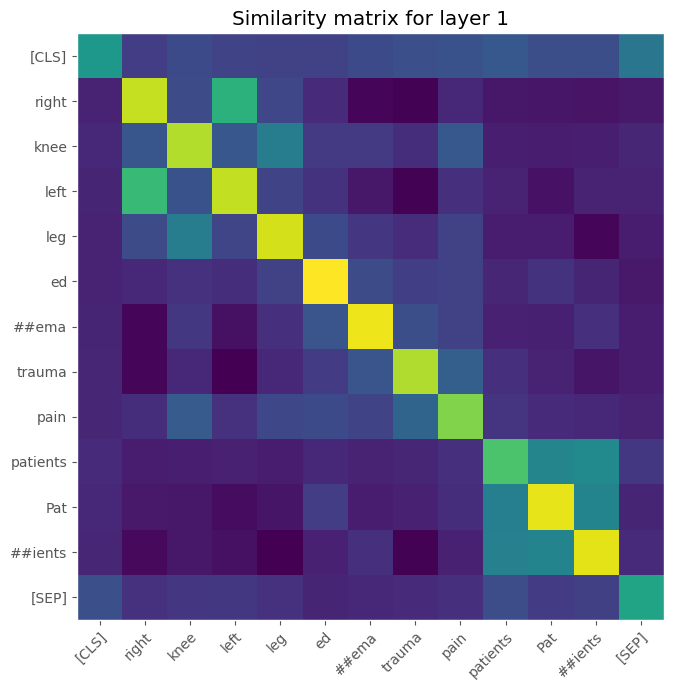

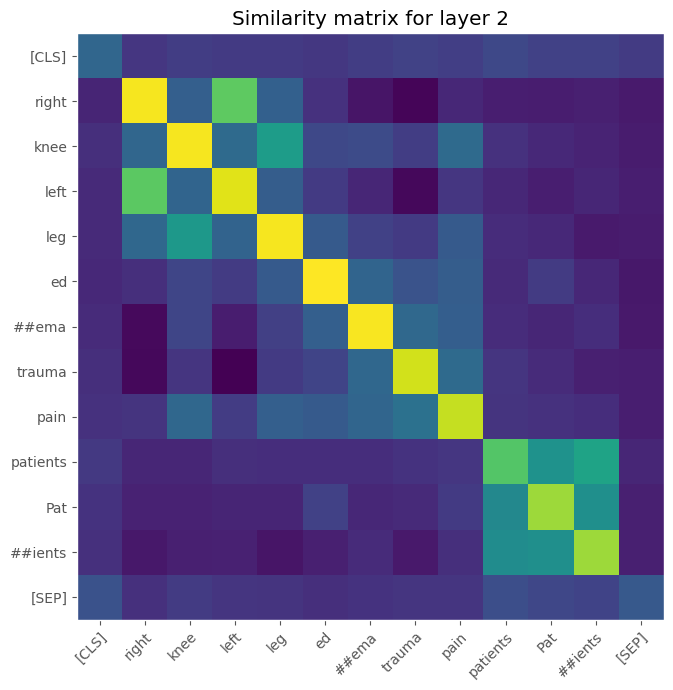

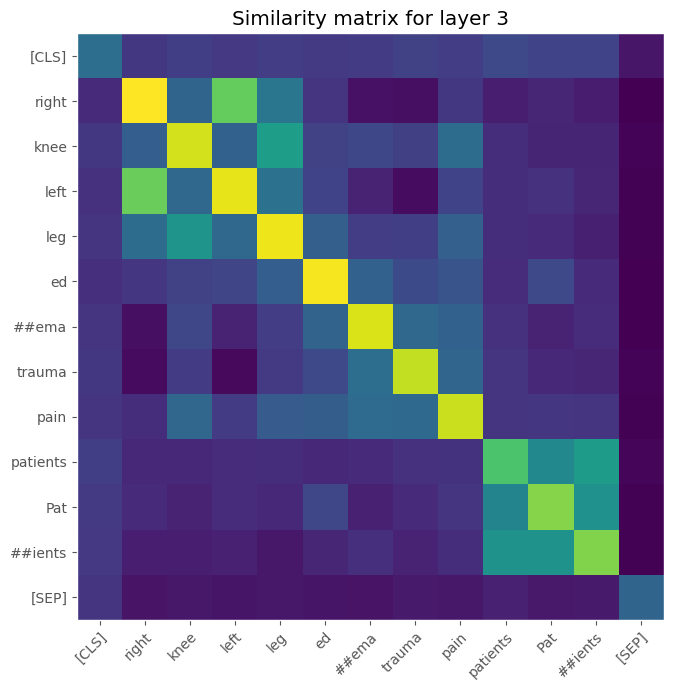

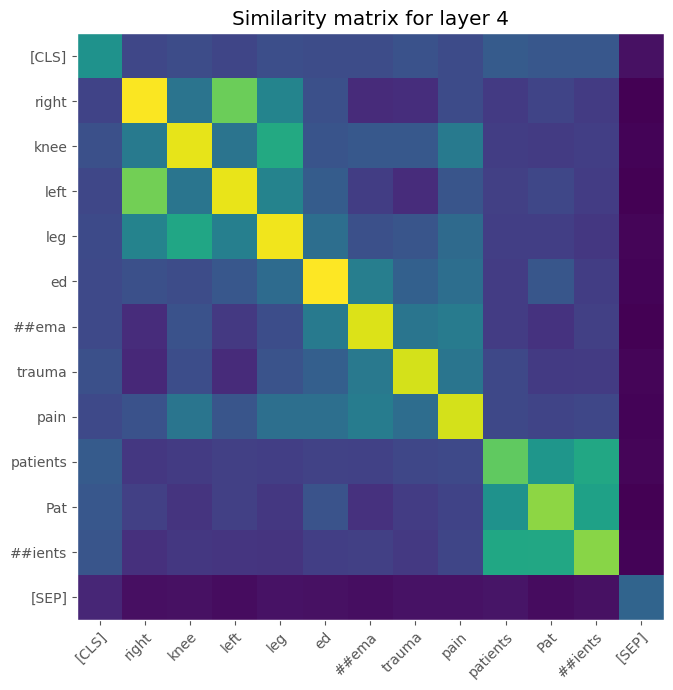

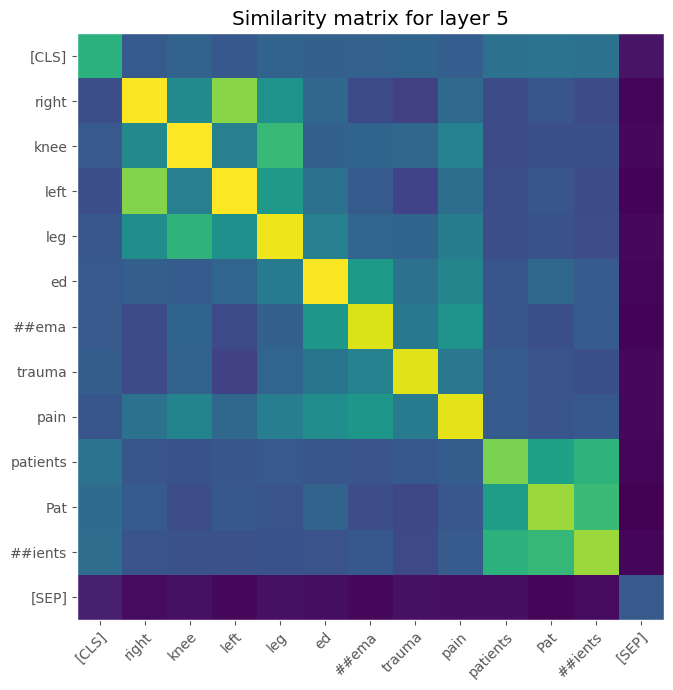

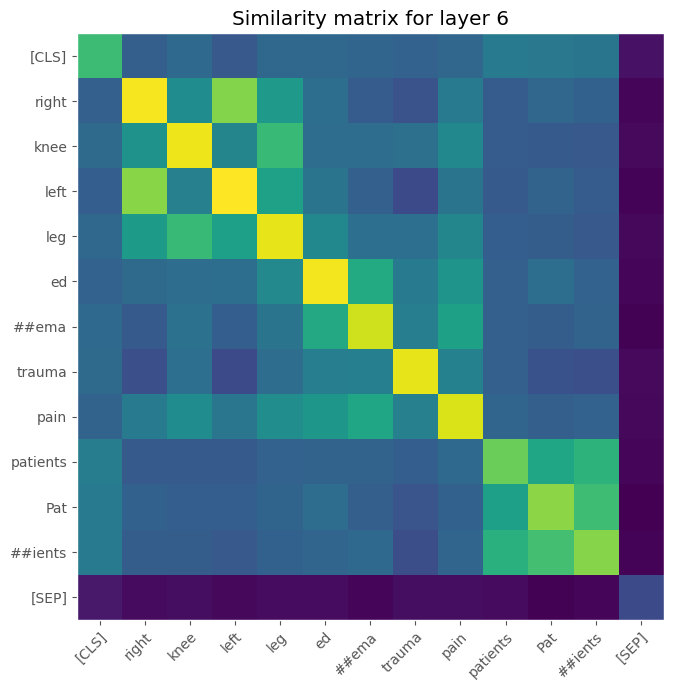

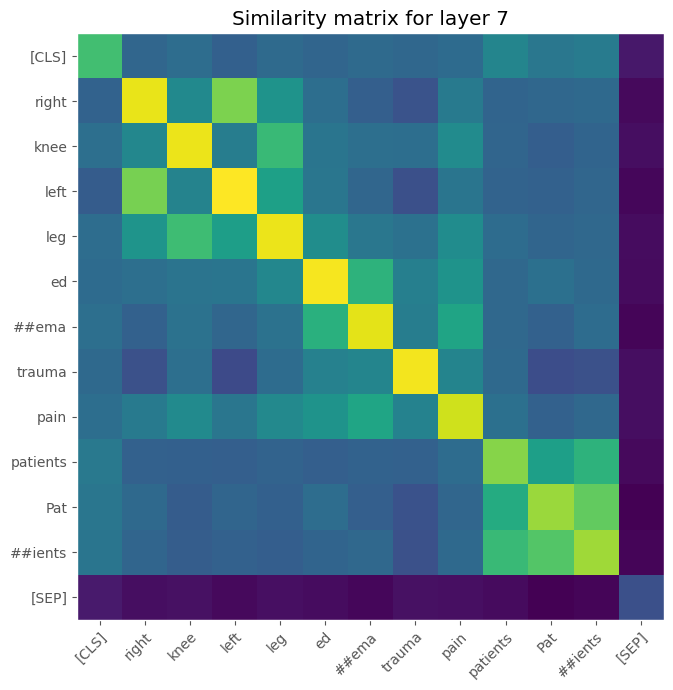

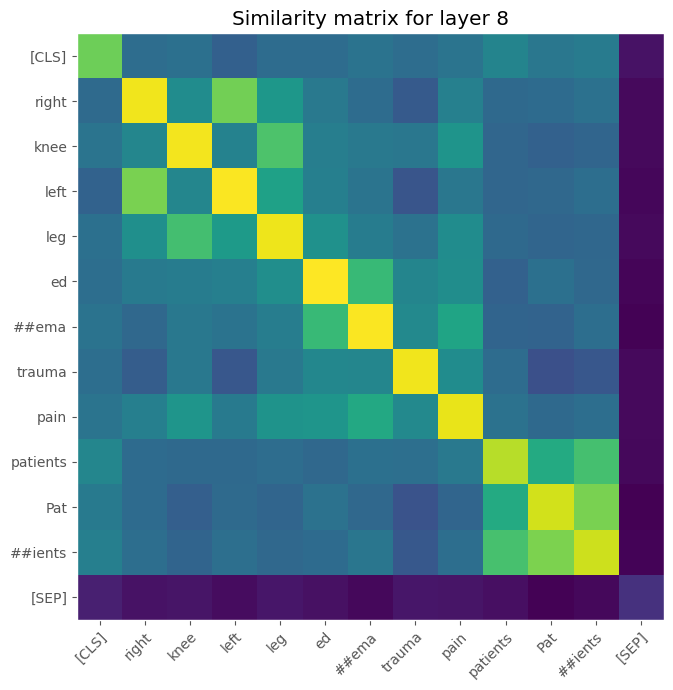

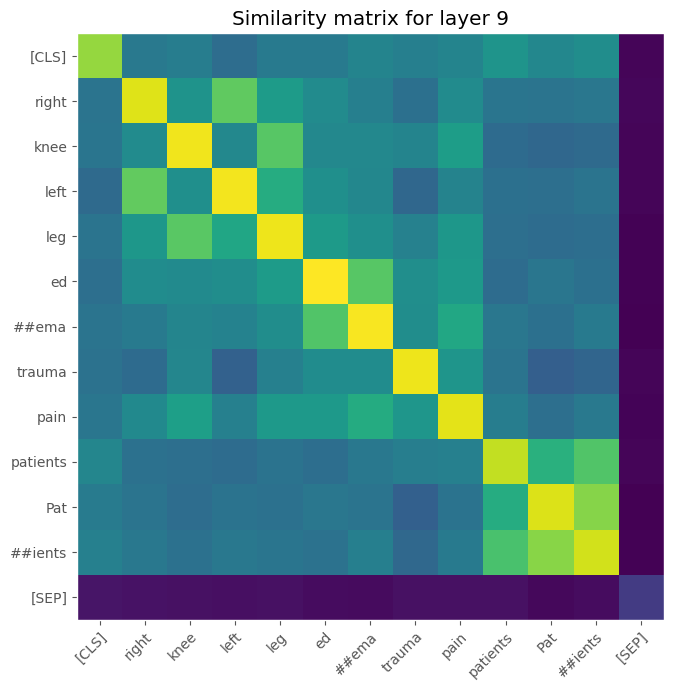

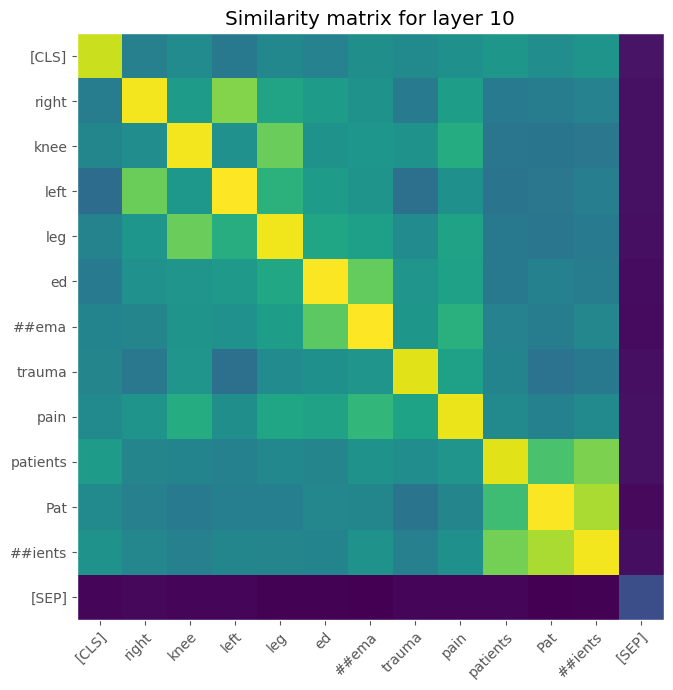

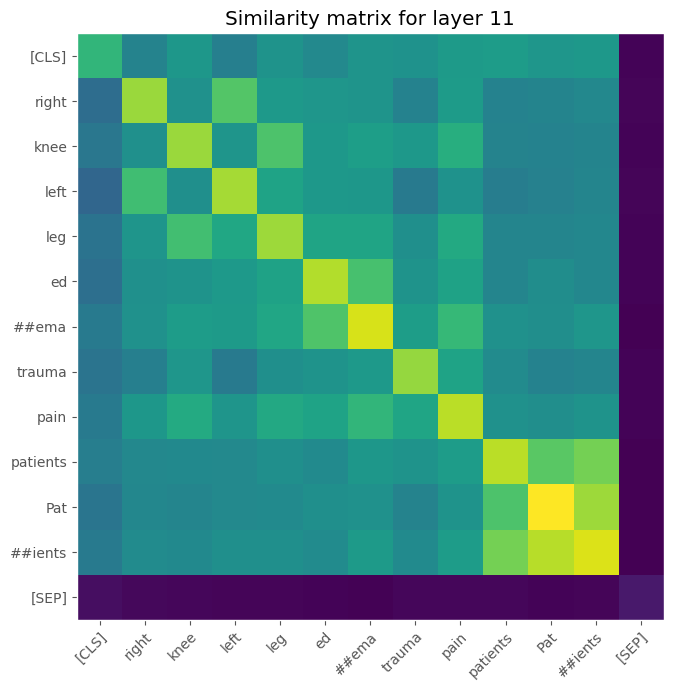

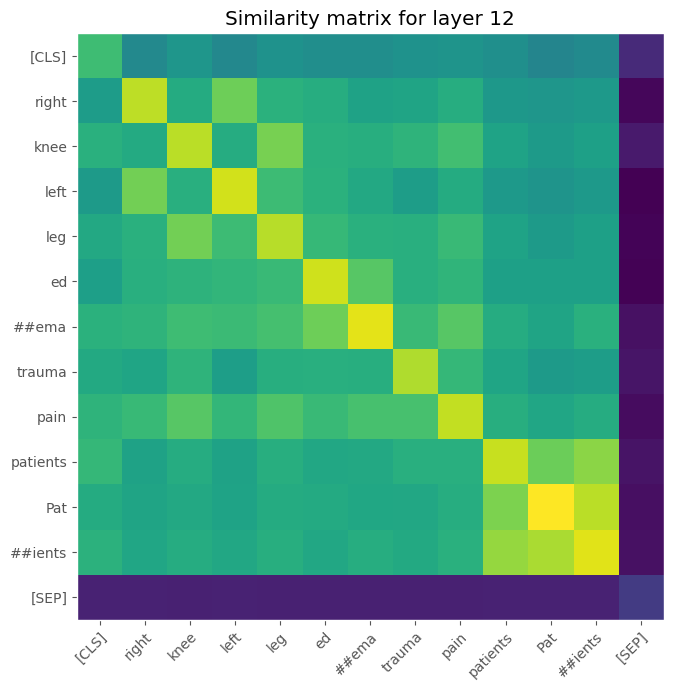

In [25]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
query, doc = query_3, n_rel_doc_3

token_idx = [0, 9, 10, 12, 13, 16, 17, 34, 14, -15, -40, -39, -1]

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

with torch.no_grad():
    outputs = model(**inputs)
    
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))
    
plt.rcParams["axes.grid"] = False

for i in range(0, 12):
    layer_input = outputs['hidden_states'][i][0][token_idx]
    layer_output = outputs['hidden_states'][i+1][0][token_idx]
    
    similarity_matrix = dot(layer_input, layer_output)

    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(7)
    
    im = ax.imshow(similarity_matrix)
    l = similarity_matrix.shape[0]

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(l), labels=tokens[token_idx])
    ax.set_yticks(np.arange(l), labels=tokens[token_idx])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Similarity matrix for layer %d" % (i+1))
    fig.tight_layout()
    plt.show()

# Self-attention head visualization

In [32]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

### First query-doc pair

In [48]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

query, doc = query_2, rel_doc_2
token_idx = [0, 354, 355, 1, 3, 9, 10, 11, 12, 6, 7, 407]

#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
#query, doc = query_3, n_rel_doc_3

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

with torch.no_grad():
    outputs = model(**inputs)
    
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

attention = (torch.Tensor(np.array(outputs['attentions'][0]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][1]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][2]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][3]).take(token_idx, axis = 2).take(token_idx, axis = 3)), 
            torch.Tensor(np.array(outputs['attentions'][4]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][5]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][6]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][7]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][8]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][9]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][10]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][11]).take(token_idx, axis = 2).take(token_idx, axis = 3)))

In [49]:
tokens = list(np.array(tokens)[token_idx])
call_html()
html_view = head_view(attention, tokens, html_action='return')

with open("head_view_1.html", 'w') as file:
    file.write(html_view.data)

In [50]:
html_view = model_view(attention, tokens, html_action="return")

with open("model_view_1.html", 'w') as file:
    file.write(html_view.data)

### Second query-doc pair

In [51]:
#query, doc = query_1, rel_doc_1
#query, doc = query_1, n_rel_doc_1

#query, doc = query_2, rel_doc_2
#query, doc = query_2, n_rel_doc_2

#query, doc = query_3, rel_doc_3
query, doc = query_3, n_rel_doc_3

token_idx = [0, 9, 10, 12, 13, 16, 17, 14, -15, -40, -39, -1]

inputs = tokenizer.encode_plus(query, doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

with torch.no_grad():
    outputs = model(**inputs)
    
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = np.array(tokenizer.convert_ids_to_tokens(input_id_list))

attention = (torch.Tensor(np.array(outputs['attentions'][0]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][1]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][2]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][3]).take(token_idx, axis = 2).take(token_idx, axis = 3)), 
            torch.Tensor(np.array(outputs['attentions'][4]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][5]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][6]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][7]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][8]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][9]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][10]).take(token_idx, axis = 2).take(token_idx, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][11]).take(token_idx, axis = 2).take(token_idx, axis = 3)))

In [52]:
tokens = list(np.array(tokens)[token_idx])
call_html()
html_view = head_view(attention, tokens, html_action='return')

with open("head_view_2.html", 'w') as file:
    file.write(html_view.data)

In [53]:
html_view = model_view(attention, tokens, html_action="return")

with open("model_view_2.html", 'w') as file:
    file.write(html_view.data)

# Learning to rank

In [7]:
from bert_letor import BERT_LETOR, get_CV_metrics, loadDatasets

In [8]:
train_dataset, test_dataset = loadDatasets()

### Perofrm cross validation to find the best parameters for the model

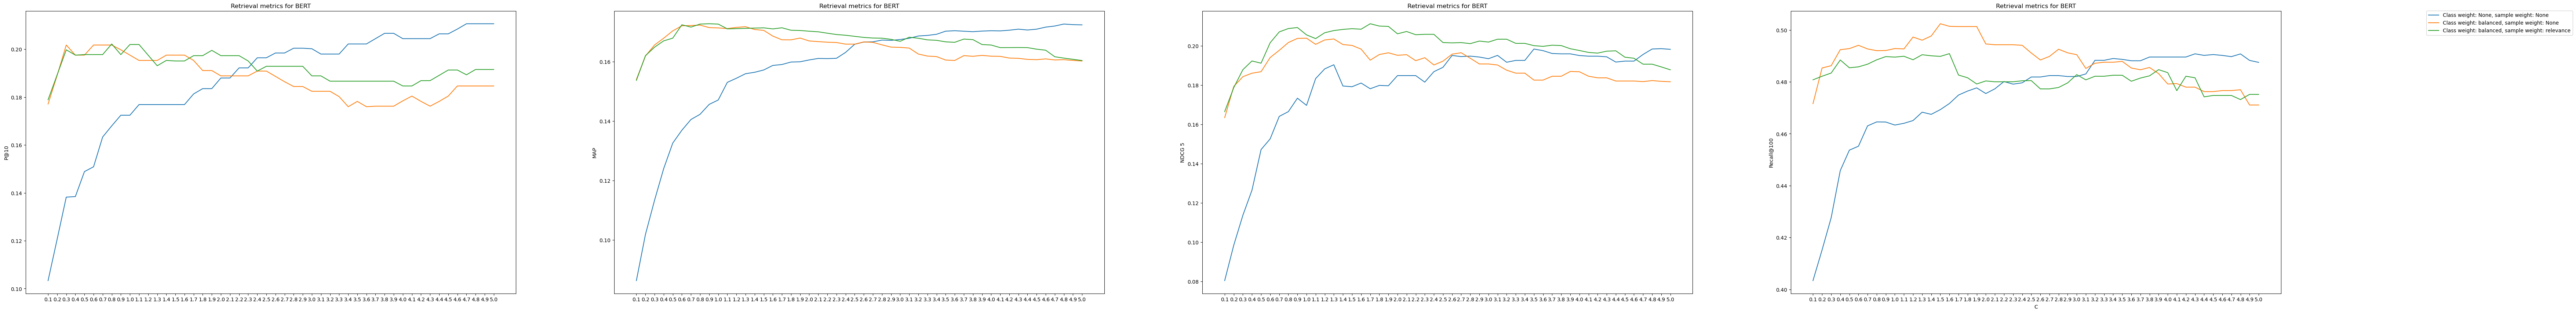

In [8]:
C = np.arange(0.1, 5.1, 0.1)
class_w = [None, "balanced", "balanced"]
sample_w = [None, None, "relevance"]

all_metrics = []

for k in range(0, 3):
    metrics = np.zeros((len(C), 4))

    for idx, c in enumerate(C):
        bert_letor = BERT_LETOR(train_dataset, test_dataset, docs = trials, C = c, class_weight = class_w[k],
                                sample_weight = sample_w[k])
    
        metrics[idx] = np.array(get_CV_metrics(bert_letor, train, sample_weight = sample_w[k]))
    all_metrics.append(metrics)

all_metrics = np.array(all_metrics)
metric_names = ["P@10", "MAP", "NDCG 5", "Recall@100"]

plt.style.use('default') 
plt.figure(figsize=(100,10))

for i in range(0, 4):
    plt.subplot(1,5,i+1)
    for j in range(0, 3):
            plt.plot(C, all_metrics[j, :, i], label = "Class weight: %s, sample weight: %s" %(class_w[j], sample_w[j]))
            plt.ylabel(metric_names[i])
            plt.xticks(C)
            plt.title("Retrieval metrics for BERT")
plt.legend(bbox_to_anchor = (1.6,1.01))
plt.xlabel("C",{'x':-1.9})
plt.show()

### We choose C = 4.9 for class weight None and sample weight None

In [10]:
bert_letor = BERT_LETOR(train_dataset, test_dataset, docs = trials, C = 4.9,
                        class_weight = None, sample_weight = None)
bert_letor.fitModel()

### We test different filter configurations

In [24]:
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = bert_letor.get_top_query_results(query, test_set = False, gender_filter = False, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("No filters")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = bert_letor.get_top_query_results(query, test_set = False, gender_filter = True, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("Gender filter on")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = bert_letor.get_top_query_results(query, test_set = False, gender_filter = False, age_filter = True)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("Age filter on")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = bert_letor.get_top_query_results(query, test_set = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("All filters on")
print(df_metrics.loc['average'])

No filters
P@10                                                            0.23617
recall                                                         0.569467
AP                                                             0.209379
NDCG5                                                          0.258177
MRR                                                            0.005035
11-point-precision    [0.5093917093213258, 0.40997598729739837, 0.34...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


Gender filter on
P@10                                                            0.23617
recall                                                         0.567255
AP                                                             0.207853
NDCG5                                                          0.258177
MRR                                                            0.005035
11-point-precision    [0.5094091662086401, 0.4105303764327777, 0.347...
11-po

### Final evaluation of all the models

P@10                                                           0.058333
recall                                                           0.1283
AP                                                             0.040118
NDCG5                                                          0.077172
MRR                                                              0.0057
11-point-precision    [0.33271710175225044, 0.1407018399511872, 0.08...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object
P@10                                                           0.108333
recall                                                         0.244267
AP                                                             0.083188
NDCG5                                                          0.148573
MRR                                                              0.0057
11-point-precision    [0.4789009728803307, 0.3555308201282177, 0.214...
11-point-recall       [0.0, 0.09999

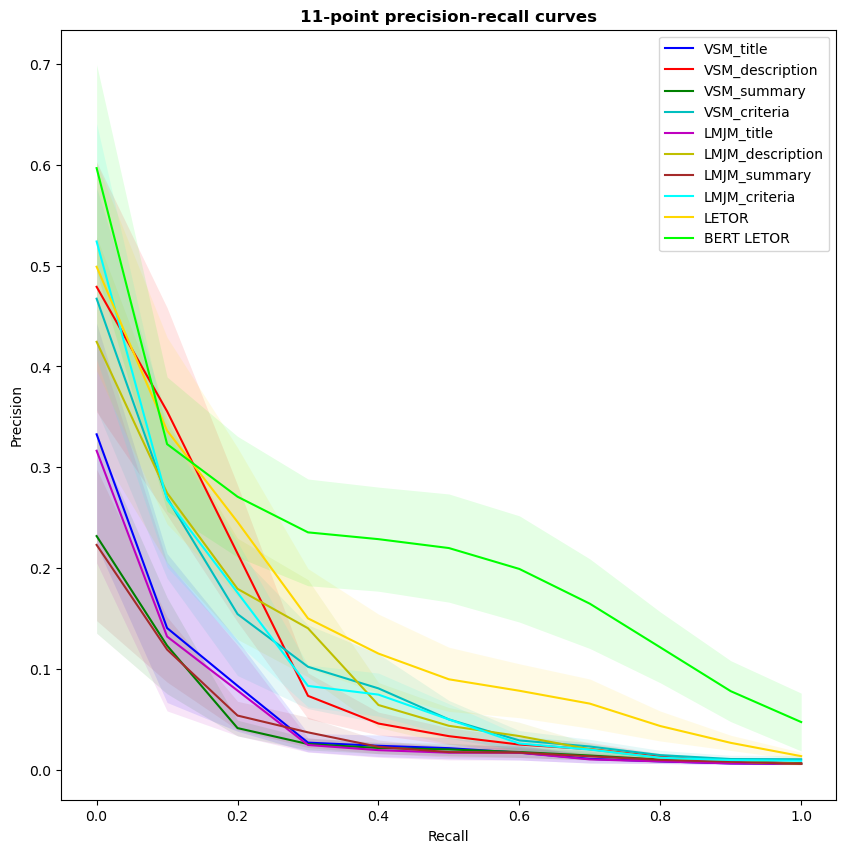

In [25]:
from letor import LETOR, loadDataset

if (exists('vsm_models.obj') and exists('lmjm_models.obj')):    
        #load the objects from pickle
        file_data = open('vsm_models.obj', 'rb') 
        VSM_models = pickle.load(file_data)
        file_data.close()
    
        file_data = open('lmjm_models.obj', 'rb') 
        LMJM_models = pickle.load(file_data)
        file_data.close()
        
base_models = [*VSM_models, *LMJM_models]

dataset = loadDataset()

letor_model = LETOR(dataset, trials, class_weight='balanced', sample_weight='relevance', max_d=5)
letor_model.fitModel()

bert_letor = BERT_LETOR(train_dataset, test_dataset, docs = trials, C = 4.9,
                        class_weight = None, sample_weight = None)
bert_letor.fitModel()


test_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])

for idx, model in enumerate(base_models):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    for query in test:
        search_results = model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
    
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]

    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    print(df_metrics.loc['average'])
    
    std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
    se_recall = std_recall/np.sqrt(len(test))

    std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
    se_precision = std_precision/np.sqrt(len(test))
    
    test_metrics.loc[idx] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]

# Now LETOR model
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in test:
    search_results = letor_model.get_top_query_results(query)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                        eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                df_metrics['MRR'].mean(), 
                                np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
print(df_metrics.loc['average'])
    
std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
se_recall = std_recall/np.sqrt(len(test))

std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
se_precision = std_precision/np.sqrt(len(test))
    
test_metrics.loc[8] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]

# Now BERT letor
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in test:
    search_results = bert_letor.get_top_query_results(query, test_set = True, gender_filter = False, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                        eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                df_metrics['MRR'].mean(), 
                                np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
print(df_metrics.loc['average'])
    
std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
se_recall = std_recall/np.sqrt(len(test))

std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
se_precision = std_precision/np.sqrt(len(test))
    
test_metrics.loc[9] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]

#Plot the 11-point precision recall curves   
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'brown', 'aqua', 'gold', 'lime']
plt.style.use('default')
plt.figure(figsize=(10, 10))

for i in range(0, 10):   
    plt.plot(test_metrics.loc[i]['11-point-recall'],
             test_metrics.loc[i]['11-point-precision'], color = colors[i])

    plt.fill_between(test_metrics.loc[i]['11-point-recall'],
                     test_metrics.loc[i]['11-point-precision'] - test_metrics.iloc[i]['se-precision'],
                     test_metrics.loc[i]['11-point-precision'] + test_metrics.iloc[i]['se-precision'],
                     alpha = 0.1, color=colors[i], linewidth = 0, label='_nolegend_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['VSM_title', 'VSM_description', 'VSM_summary', 'VSM_criteria',
            'LMJM_title', 'LMJM_description', 'LMJM_summary', 'LMJM_criteria',
            'LETOR', 'BERT LETOR'])

# Failure anaysis

In [11]:
bert_letor = BERT_LETOR(train_dataset, test_dataset, docs = trials, C = 4.9,
                        class_weight = None, sample_weight = None)
bert_letor.fitModel()


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = bert_letor.get_top_query_results(query, test_set = False, gender_filter = False, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

## Best MAP

Text(0, 0.5, 'MAP')

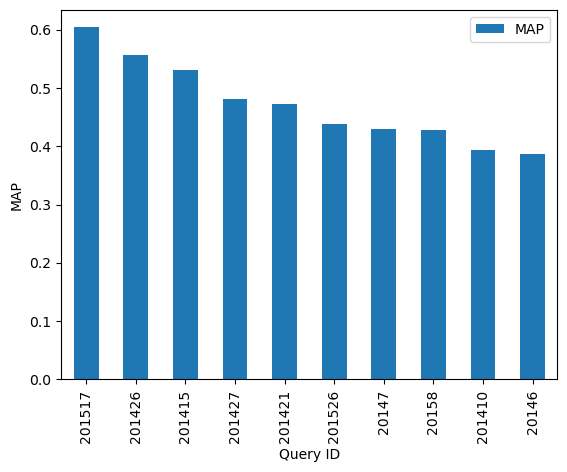

In [13]:
df_metrics = df_metrics.rename(columns={"AP": "MAP"})
plt.style.use('default')
ax = df_metrics.nlargest(10, 'MAP').plot.bar(y = 'MAP')
ax.set_xlabel("Query ID")
ax.set_ylabel("MAP")

In [14]:
ids = np.array([query.query_id for query in train])

queries = ['201517', '201426', '201415', '201427', '201421', '201526', '20147', '20158', '201410', '20146']

for q in queries:
    i = np.where(ids == q)[0][0]
    print(train[i].query_content)

A 32 year old female with screening that was positive for human papilloma virus with normal Pap smears.
       		
Group traveling to the Amazon rainforest, including 3 pregnant women. All members' immunizations are up-to-date but they require malaria prophylaxis.
       		
36-year-old woman with amenorrhea, abdominal tenderness, enlarged uterus, and cervical dilation. Urine pregnancy test is negative. Ultrasound reveals an enlarged uterus with multiple cystic areas, which could be consistent with vesicular mole and fibroid degeneration.
       		
21-year-old male with dozens of small polyps found on colonoscopy. Family history significant for both older siblings having total colectomies after colonoscopy revealed hundreds of adenomas.
       		
21-year-old female with progressive arthralgias, fatigue, and butterfly-shaped facial rash. Labs are significant for positive ANA and anti-double-stranded DNA, as well as proteinuria and RBC casts.
       		
An obese 28 yo female with non-ruptur

## Worst MAP

Text(24.000000000000007, 0.5, 'MAP')

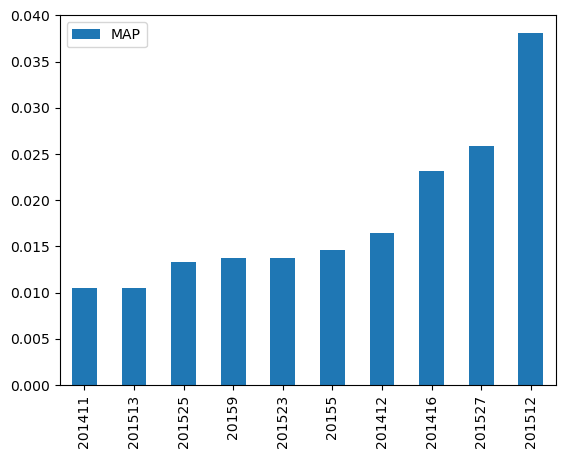

In [15]:
df_metrics = df_metrics.rename(columns={"AP": "MAP"})
df_metrics.nsmallest(10, 'MAP').plot.bar(y = 'MAP')
ax.set_xlabel("Query ID")
ax.set_ylabel("MAP")

In [16]:
ids = np.array([query.query_id for query in train])

queries = ['201411', '201513', '201525', '20159', '201523', '20155', '201412', '201416', '201527', '201512']

for q in queries:
    i = np.where(ids == q)[0][0]
    print(train[i].query_content)

40-year-old woman with severe right arm pain and hypotension. She has no history of trauma and right arm exam reveals no significant findings.
       		
A 5-year-old boy presents with difficulty in breathing, stridor, drooling, fever, dysphagia and voice change.
       		
10-year-old boy with progressive right knee and left leg pain and edema, lethargy and an osteolytic lesion. No history of trauma, fever, tachycardia, or urinary incontinence.
       		
A 10 year old child with recent history of pork consumption presents with fever, myalgia, facial edema and eosinophilia
       		
An 18-year-old male returned from Asia a week ago. He presents with high fever, severe headache and joint pain. His blood analysis reveals leukopenia, increased hematocrit and thrombocytopenia.
       		
Young adult woman with 2 weeks of fever and migrating joint inflammation.
       		
25-year-old woman with fatigue, hair loss, weight gain, and cold intolerance for 6 months.
       		
28-year-old female with